In [1]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import pickle
import os
import re

#### Utility to get similarity between two texts

In [2]:
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]


'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    text1 = removeSpecialChars(text1)
    text2 = removeSpecialChars(text2)
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

def removeSpecialChars(text):
    return re.sub("[^a-zA-Z0-9]", " ", text)

#### Utility to extract method name

In [3]:
from collections import deque

class FunctionCallVisitor(ast.NodeVisitor):
    def __init__(self):
        self._name = deque()
    
    @property
    def name(self):
        return '.'.join(self._name)
    
    @name.deleter
    def name(self):
        self._name.clear()
    
    def visit_Name(self, node):
        self._name.appendleft(node.id)
    
    def visit_Attribute(self, node):
        try:
            self._name.appendleft(node.attr)
            self._name.appendleft(node.value.id)
        except AttributeError:
            self.generic_visit(node)
            
def get_func_calls(tree):
    func_calls = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            callvisitor = FunctionCallVisitor()
            callvisitor.visit(node.func)
            func_calls.append(callvisitor.name)
    return func_calls

#### Load APIDoc and Dataset

In [4]:
API_DOC_FILE_PATH = 'api_doc.pkl'
DATASET_FILE_PATH = 'dataset_df.pkl'
api_df = pickle.load( open( API_DOC_FILE_PATH, "rb" ))
dataset_df = pickle.load( open( DATASET_FILE_PATH, "rb" ))

def buildAPIDictionaryWithContext(api_df):
    api_dict = dict()
    
    for index, row in api_df.iterrows():
        methodContext = row['Description']
        tokens = row['FullyQualifiedName'].split('.')
        for token in tokens:
            methodContext = methodContext+' '+token
        api_dict[row['MethodName']] = methodContext
    return api_dict
        

def buildDatasetDSForEvaluation(dataset_df):
    dataset_dict = dict()
    total_solutions = 0
    try:    
        for idx, row in dataset_df.iterrows():
            answerId = row['AnswerId']
            if answerId != 0:
                total_solutions = total_solutions +1
                tup = (int(row['SolutionId']), row['Solution'])
                if answerId in dataset_dict:
                    ls = dataset_dict[answerId]
                    ls.append(tup)
                    dataset_dict[answerId] = ls
                else:
                    ls = list()
                    ls.append(tup)
                    dataset_dict[answerId] = ls
    except Exception as e:
        print e
        
    return dataset_dict, total_solutions

def buildAnswerIdQuestionTextDict(dataset_df):
    dataset_answerId_QText_Dict = dict()
    try:
        for idx, row in dataset_df.iterrows():
            answerId = row['AnswerId']
            if answerId != 0:
                dataset_answerId_QText_Dict[answerId] = row['QuestionText']
    except Exception as e:
        print e
        
    return dataset_answerId_QText_Dict
    
api_dict = buildAPIDictionaryWithContext(api_df)
#print api_dict
dataset_dict, total_solutions = buildDatasetDSForEvaluation(dataset_df)
print total_solutions

dataset_answerId_QText_Dict = buildAnswerIdQuestionTextDict(dataset_df)

cannot convert float NaN to integer
120


In [5]:
def lookUpAPIDocForContext(method_name):
    if method_name in api_dict.keys():
        return api_dict[method_name]
    else:
        return method_name

def getSOContext(answerId):
    return dataset_answerId_QText_Dict[int(answerId)]

all the lines --> tp +tn + fp+fn
tp-> identified as solution and the solution
fp-> identified as solution but not the solution
tn-> not identified as solution and also not the solution
fn-> not identified as solution but the solution

Accuracy: (tp+tn)/(tp+tn+fp+fn)
Precision: tp/(tp+fp)
Recall: tp/(tp+fn)
F1: (2*P*R)/(P+R)

TP-> Lines identified as solution are the solution
TN -> Lines not identified as solution are not the solution

In [6]:
PROCESSED_CODE_OUTPUT_FOLDER = '../../data-preprocess/neelesh/processed_answer_codes'

def evaluate(cosine_sim_thresould):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for fil in os.listdir(PROCESSED_CODE_OUTPUT_FOLDER):
        try:
            solutionList = dataset_dict[int(fil)]
            with open(os.path.join(PROCESSED_CODE_OUTPUT_FOLDER, fil), 'r') as f:
                lines = f.readlines()
                #print f
                for line in lines:
                    actualSolution = False
                    predictedSolution = False
                    for tup in solutionList:
                        if tup[1].strip() == line.strip():
                            actualSolution = True
                
                    tree = ast.parse(line)
                    func_calls = get_func_calls(tree)
                    for func_call in func_calls:
                        tokens = func_call.split('.')
                        method_name = tokens[len(tokens)-1]
                        API_Context = lookUpAPIDocForContext(method_name)
                        #print 'API: ', API_Context, 'Method_Name: ', method_name
                        SO_Context = getSOContext(fil)
                        cos_score = cosine_sim(API_Context, SO_Context)
                        #print 'API: ', API_Context, 'SO: ', SO_Context, 'COS: ', cos_score, '\n'
                        if cos_score > cosine_sim_thresould:
                            predictedSolution = True
                            break
                
                    if actualSolution and predictedSolution:
                        TP = TP + 1
                    if (not actualSolution) and predictedSolution:
                        FP = FP + 1
                    if (not actualSolution) and (not predictedSolution):
                        TN = TN + 1
                    if actualSolution and (not predictedSolution):
                        FN = FN + 1
        except Exception as e:
            print e
    #acc = (TP+TN)*100/(TP+TN+FP+FN)
    #return acc
    Precision = 0
    Recall = 0
    F1 = 0
    if TP == 0:
        Precision = 0
        Recall = 0
    else:
        Precision = float(TP)/(TP + FP)
        Recall = float(TP)/(TP + FN)
    if (Precision == 0)  and (Recall == 0):
        return 0, 0, 0
    else:
        F1 = (2*Precision*Recall)/(Precision+Recall)
    return F1*100, Precision*100, Recall*100

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


17841294
Cosine Sim:  0.0 Precison:  65.0485436893 Recall:  88.1578947368 F1:  74.8603351955 

17841294
Cosine Sim:  0.1 Precison:  72.1518987342 Recall:  75.0 F1:  73.5483870968 

17841294
Cosine Sim:  0.2 Precison:  69.696969697 Recall:  30.2631578947 F1:  42.2018348624 

17841294
Cosine Sim:  0.30000000000000004 Precison:  75.0 Recall:  15.7894736842 F1:  26.0869565217 

17841294
Cosine Sim:  0.4 Precison:  88.8888888889 Recall:  10.5263157895 F1:  18.8235294118 

17841294
Cosine Sim:  0.5 Precison:  100.0 Recall:  9.21052631579 F1:  16.8674698795 

17841294
Cosine Sim:  0.6000000000000001 Precison:  100.0 Recall:  2.63157894737 F1:  5.12820512821 

17841294
Cosine Sim:  0.7000000000000001 Precison:  100.0 Recall:  2.63157894737 F1:  5.12820512821 

17841294
Cosine Sim:  0.8 Precison:  0 Recall:  0 F1:  0 

17841294
Cosine Sim:  0.9 Precison:  0 Recall:  0 F1:  0 

17841294
Cosine Sim:  1.0 Precison:  0 Recall:  0 F1:  0 

[74.8603352  73.5483871  42.20183486 26.08695652 18.82352941

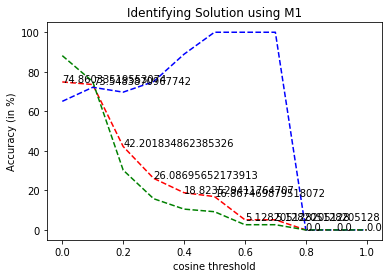

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 1.1, .1)
precision = list()
recall = list()
f1 = list()
for num in np.nditer(x):
    f, p, r = evaluate(num)
    print 'Cosine Sim: ', num, 'Precison: ', p, 'Recall: ', r, 'F1: ', f, '\n'
    f1.append(f)
    precision.append(p)
    recall.append(r)

precision = np.array(precision)
recall = np.array(recall)
f1 = np.array(f1)
print f1

plt.plot(x, f1, 'r--',  x, precision, 'b--',   x, recall, 'g--')
for a,b in zip(x, f1): 
    plt.text(a, b, str(b))

plt.ylabel('Accuracy (in %)')
plt.xlabel('cosine threshold')
plt.title('Identifying Solution using M1')
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.show()